In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import pymc as pm

## 先验分布

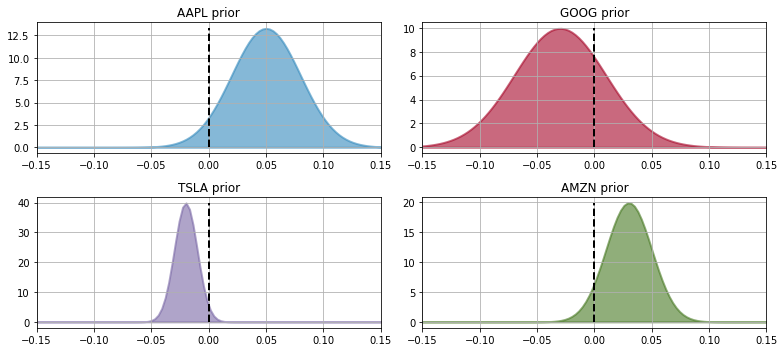

In [6]:
plt.figure(figsize=(11., 5))
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

x = np.linspace(-0.15, 0.15, 100)
expert_prior_params = {
    "AAPL": (0.05, 0.03),
    "GOOG": (-0.03, 0.04),
    "TSLA": (-0.02, 0.01),
    "AMZN": (0.03, 0.02),
}

for i, (name, (mu, std)) in enumerate(expert_prior_params.items()):
    y = ss.norm.pdf(x, loc=mu, scale=std)
    plt.subplot(2, 2, i + 1)
    plt.fill_between(x, 0, y, color=colors[i], linewidth=2, edgecolor=colors[i], alpha=0.6)
    plt.title(f"{name} prior")
    plt.vlines(0, 0, y.max(), "k", linestyles="--", lw=2)
    plt.xlim(-0.15, 0.15)
    plt.grid()

plt.tight_layout()
    

In [97]:
n = 100

## 实际数据

In [83]:
import datetime
import requests

def to_timestamp(date: str):
    return int(datetime.datetime.strptime(date, "%Y-%m-%d").timestamp())

def get_historical_prices(symbol, start_date, end_date):
    start_ts, end_ts = map(to_timestamp, [start_date, end_date])
    url = f"https://query1.finance.yahoo.com/v8/finance/chart/{symbol}?symbol={symbol}&period1={start_ts}&period2={end_ts}&interval=1d"
    r = requests.get(url)
    data = r.json()["chart"]["result"][0]
    return np.array(data["indicators"]["quote"][0]["close"])

In [84]:
stocks = ["AAPL", "GOOG", "TSLA", "AMZN"]
end_date = "2020-06-14"
start_date = "2020-01-01"

stock_closes = {stock: get_historical_prices(stock, start_date, end_date) for stock in stocks}

In [85]:
stock_returns = {}
for stock, prices in stock_closes.items():
    today = prices[1:]
    previous = prices[:-1]
    stock_returns[stock] = ((today - previous) / previous)[:n]

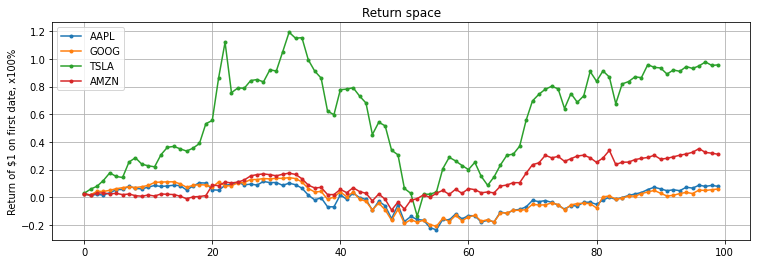

In [91]:
plt.figure(figsize=(12.5, 4))
for stock, returns in stock_returns.items():
    plt.plot((1 + returns).cumprod() - 1, "-o", label=stock, 
             markersize=4, markeredgecolor="none")
plt.legend(loc="upper left")
plt.title("Return space")
plt.ylabel("Return of $1 on first date, x100%")
plt.grid()

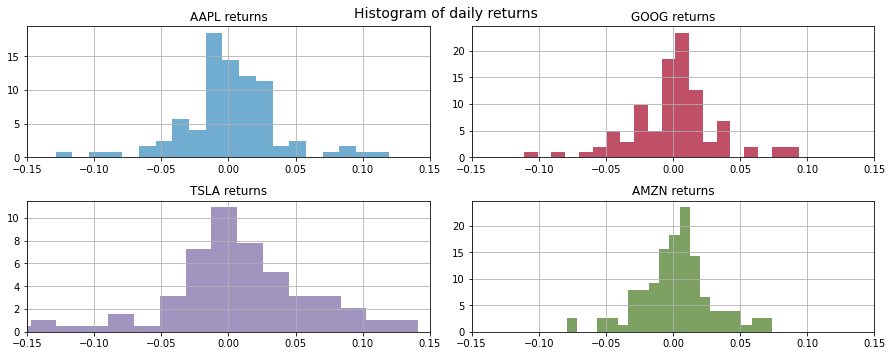

In [96]:
plt.figure(figsize=(12.5, 5))
returns = np.zeros((n, len(stocks)))
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

for i, (stock, _returns) in enumerate(stock_returns.items()):
    returns[:, i] = _returns
    ax = plt.subplot(2, 2, i + 1)
    ax.hist(_returns, bins=20, density=True, histtype="stepfilled", color=colors[i], alpha=0.7)
    ax.set_title(f"{stock} returns")
    ax.set_xlim(-0.15, 0.15)
    ax.grid()
plt.tight_layout()
plt.suptitle("Histogram of daily returns", size=14);

## 后验推断

In [101]:
# n = 100
prior_mu = np.array([0.05, -0.03, -0.02, 0.03])
prior_std = np.array([0.03, 0.04, 0.01, 0.02])

inv_cov_matrix = pm.Wishart("inv_cov_matrix", n, np.diag(prior_std ** 2))
mu = pm.Normal("returns", prior_mu, 1, size=4)
obs = pm.MvNormal("obs", mu, inv_cov_matrix, observed=True, value=returns)
model = pm.Model([obs, mu, inv_cov_matrix])
mcmc = pm.MCMC(model)

mcmc.sample(150000, 100000, 3)

C:\ProgramData\Anaconda3\lib\site-packages\pymc\MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 [-----------------100%-----------------] 150000 of 150000 complete in 73.8 sec

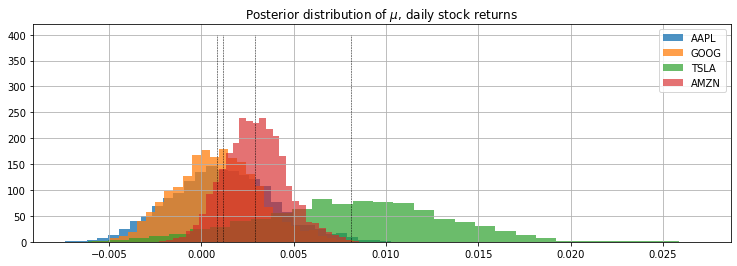

In [104]:
mu_samples = mcmc.trace("returns")[:]

plt.figure(figsize=(12.5, 4))
for i, stock in enumerate(stocks):
    plt.hist(mu_samples[:, i], alpha=0.8 - 0.05 * i, bins=30, 
             histtype="stepfilled", density=True, label=stock)
plt.vlines(mu_samples.mean(axis=0), 0, 400, linestyle="--", linewidth=0.5)
plt.title("Posterior distribution of $\mu$, daily stock returns")
plt.grid()
plt.legend()

In [109]:
# 威沙特分布模型得到的是协方差矩阵的逆
inv_cov_samples = mcmc.trace("inv_cov_matrix")[:].mean(axis=0)
mean_covariance_matrix = np.linalg.inv(inv_cov_samples)

In [110]:
def cov2corr(A):
    d = np.sqrt(A.diagonal())
    return (A.T / d).T / d

In [118]:
corr = cov2corr(mean_covariance_matrix)
corr

array([[1.        , 0.98318377, 0.51300783, 0.97077936],
       [0.98318377, 1.        , 0.55063977, 0.97726132],
       [0.51300783, 0.55063977, 1.        , 0.61213152],
       [0.97077936, 0.97726132, 0.61213152, 1.        ]])

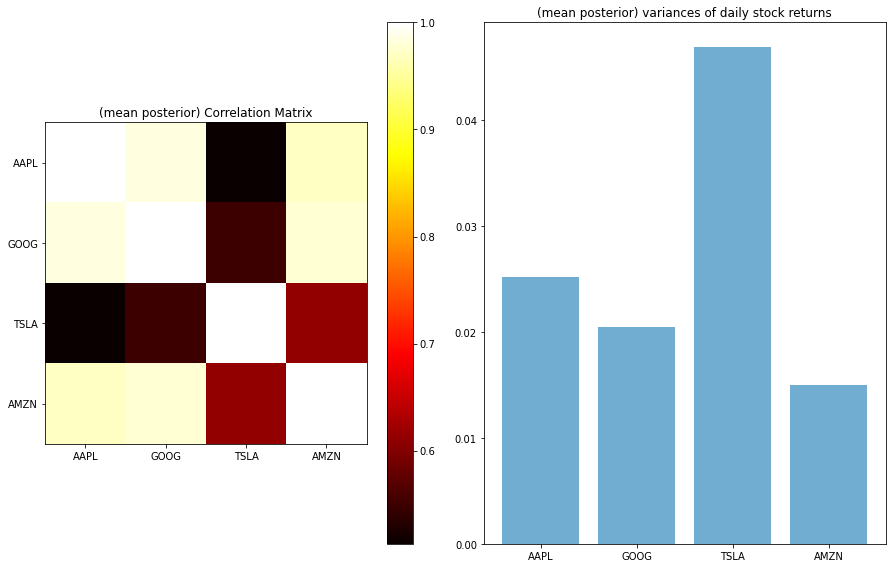

In [119]:
plt.figure(figsize=(12.5, 8))

plt.subplot(1, 2, 1)
plt.imshow(corr, interpolation="none", cmap="hot")
plt.xticks(np.arange(4), stocks)
plt.yticks(np.arange(4), stocks)
plt.colorbar(orientation="vertical")
plt.title("(mean posterior) Correlation Matrix")

plt.subplot(1, 2, 2)
plt.bar(np.arange(4), np.sqrt(mean_covariance_matrix.diagonal()),
        color="#348ABD", alpha=0.7)
plt.xticks(np.arange(4), stocks);
plt.title("(mean posterior) variances of daily stock returns")

plt.tight_layout();